In [1]:
from scipy.stats import chi2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import urllib

# Read a .txt or .csv file containing SNPs and P values to be plotted
# Function checks delimiters automatically
# Parameter: filename - .txt or .csv file containing information needed
# Return: pandas dataframe of the file
def __read_file(filename):
    fh = open(filename, 'r')
    line = fh.readline()
    if line=='': return None # Empty file, return None
    
    tmp = line.strip().split(',')

    # Create an empty dataframe, read data into df later
    df = pd.DataFrame()
    # Check delimiter type, "," or " "
    if len(tmp) == 1:
        df = pd.read_csv(filename, delim_whitespace=True)
    else:
        df = pd.read_csv(filename)
    
    # File only has a line of tile, return None  
    if len(df)==0: return None 
    
    return(df)

# Return -log10 transformed observed and expected p vlaues of a dataset(dataframe)
def __log_obsv_and_expt(df, column_title):
    Pobsv = df.loc[:, column_title]  # Observed p values
    Pobsv = np.sort(Pobsv.dropna().values)
    Pexpt = np.arange(1, len(Pobsv) + 1, 1) / (len(Pobsv) + 1)  # Expected
    logPobsv = -np.log10(Pobsv)
    logPexpt = -np.log10(Pexpt)
    
    return(Pobsv, logPobsv, logPexpt)


# Calculate and return lambda (inflation)
def __get_inflation__(observed):
    obsv_median = np.median(observed)
    Chi = chi2.ppf(1.0 - obsv_median, 1)
    lmbd = Chi / chi2.ppf(0.5, 1)
    return lmbd


# The tricky part for me is to query haploreg database thorugh their website.
# Inspecct the element of the website to find out names of each variable
# Recommand using Chrome, go to developer mode, refresh the website under Network tab
# This function is intended to query less than 1000 SNPs at a time, otherwise HaploReg may not be happy
# Return: a set of rsIDs of accociated SNPs (and the queried SNP)

# Parameters needed to send to haploreg website, and some explaination
# input_snps (query): input SNPs in a string, each SNP is separated by ','
#        SNP number per query is set to be 1000, otherwise it takes too long and haploreg may refuse to do it.
#        15000 SNPs did not work for test run.
# gwas_id: the dropdown list to choose GWAS study, when no file or query SNP(s) is provided
# r2_threshold (ldThresh): r^2 threshold, default is 0.2 in this code
# ldPop: 1000G Phase 1 population for LD calculation. Other options includes AFR, AMR and ASN.
# epi: Source for epigenomes
# cons: Mammalian conservation algorithm. 'siphy'=SiPhy-omega, 'gerp'=GERP, or 'both'
# genetypes: Show position relative to
# output: set output result type to 'text' for python code to process
def query_haploreg(input_snp,
                   r2_threshold=0.2,
                   ldPop='EUR',
                   epi='vanilla',
                   cons='siphy',
                   genetypes='gencode'):

    params_library = {'query':input_snp,
                      'gwas_id':0,
                      'ldThresh': r2_threshold,
                      'ldPop': ldPop,
                      'epi': epi,
                      'cons': cons,
                      'genetypes': genetypes,
                      'output':'text'}
    
    # parameters passed to the website, needs to be parsed and in binary
    params = urllib.parse.urlencode(params_library).encode("utf-8")
    # url of HaploReg4.1
    url = 'https://pubs.broadinstitute.org/mammals/haploreg/haploreg.php'
    # Query with parameters
    query = urllib.request.urlopen(url, params)
    
    # Keep console running
    print('-- Waiting for HaploReg to return results...')
    
    content = query.read().decode("utf-8")
    # Find accociated SNPs in the content returned from HaploReg
    matches = re.findall('rs[0-9]+', content)

    # Return unique ones of the query
    return(list(set(matches)))


# This function returns known SNPs (and associated SNPs) based on user input file
# Ideally know SNPs should not be more than 1500, otherwise it is too much on HaploReg v4.1
# Parameters:
#  - filename: a file contains known SNPs, provided by user
#  - r2_threshold: LD threshold, defualt is 0.2
#  - SNPs_column_title: Column title of SNPs in that file
# Return: a set of associated SNPs pulled from HaploReg and known SNPs provided by user
def __known_SNPs(filename, ldPop, r2_threshold=0.2, SNPs_column_title='SNP'):
    # Keep console running
    print('Getting associated SNPs of known SNPs from HaploReg')
    
    known_SNPs_df = __read_file(filename) # Dataframe of known SNPs
    
    # Split into smaller lists to query HaploReg (100 SNPs each query)
    count = 0
    split_point = 99
    associated_and_known_SNPs = [] # Store queried results from HaploReg in a list
    if len(known_SNPs_df)>100:
        for i in range(0,len(known_SNPs_df), 100):
            # Get SNPs to be queried, join them by ',' and query together
            known_SNPs = ','.join(known_SNPs_df.loc[:, SNPs_column_title].values[i:split_point])
            associated_and_known_SNPs = associated_and_known_SNPs + query_haploreg(input_snp=known_SNPs,
                                                                                   r2_threshold=r2_threshold,
                                                                                   ldPop=ldPop)
            
            print('  -- Number of SNPs queried: ' +  str((i+100)))
            
            if split_point+100 < len(known_SNPs_df):
                split_point = split_point+100
            else: split_point = len(known_SNPs_df)

    # Remove duplicates of queried results and return
    return(set(associated_and_known_SNPs))


# This function removes known SNPs and save novel SNPs in a .csv file
# Parameters:
#  - original_df: a dataframe containing raw data of SNPs and p values
#  - known_SNPs: a list of SNPs found in other GWAS, that are associated with traits of interest
#  - SNPs_column_title: Column title of SNPs in that file
# Return: a datafram of novel SNPs and p values
def __remove_known_SNPs(original_df, known_SNPs, SNPs_column_title='SNP', novel_filename='novel_SNPs.csv'):
    # Keep console running
    print('Removing known SNPs...')
    
    # Join the original dataframe and konw SNPs, output novel SNPs to be plotted
    original_df.set_index(SNPs_column_title, inplace=True)
    known_SNPs_df = pd.DataFrame([], index=known_SNPs)
    to_be_removed_SNPs_df = original_df.join(known_SNPs_df, how='inner')
    novel_df = original_df.drop(to_be_removed_SNPs_df.index.values)
    
    novel_df.to_csv(novel_filename)
    return(novel_df)


# Parameters:
# - filename: name of input file that contains all SNPs discovered, should starts with column titles not empty line
# - output: name of the output file to save figure of the QQ plot
# - p_value_column_title: title of the column that contains P values in the input file
# - title, xlabel, ylabel, dpi=300: label and resolution parameters of the figure
# - plot_novel: a plot of novel SNPs will be plotted with original SNPs if this is set to true.
#               User needs to supply a known SNPs file in order to look for accociated SNPs.
# - known_SNPs_filename:
# - novel_filename: 
# - SNPs_column_title: 
# - r2_threshold: LD threshold to query HaploReg for associated SNPs
# - ldPop: population for LD calculation, defult is European. Other options includes AFR, AMR and ASN.
# - plot_ci: plot shaded area of confidence interval if true
# - ci: confidence interval, default is 0.95
#
# Returns: (fig, ax, lambda)
# - fig and ax for more custermizations
def qqplot(filename,
           output='output.png',
           p_value_column_title = 'P',
           title='Q-Q plot',
           xlabel='Expected –log10 P-values',
           ylabel='Observed –log10 P-values',
           dpi=300,
           plot_novel = False,
           known_SNPs_filename='',
           novel_filename = 'novel_SNPs.csv',
           SNPs_column_title = 'SNP',
           r2_threshold=0.2,
           ldPop='EUR',
           plot_ci=False,
           ci=0.95):
    # Read in file, calsulate -log10 p values and lambda
    df = __read_file(filename)
    
    if df is None:
        print('Empty file, nothing is plotted')
        return(None, None, None) # If file is empty or only has titles, return directly
    
    fig, ax = plt.subplots(dpi=dpi)
    
    # Plot novel SNPs first, or they wil be on top of all_SNPs
    if plot_novel == True:
        if known_SNPs_filename != '':
            # Check if known SNPs file is empty
            if __read_file(known_SNPs_filename) is None:
                print('Empty file of novel SNPs')
                pass # If file is empty or only has titles, only plot original SNPs
            else:
                # Plot novel SNPs, then same steps as before
                to_be_removed_SNPs = __known_SNPs(known_SNPs_filename, ldPop, r2_threshold, SNPs_column_title)
                novel_SNPs_df = __remove_known_SNPs(df, to_be_removed_SNPs, SNPs_column_title, novel_filename)

                Pobsv_novel, logPobsv_novel, logPexpt_novel = __log_obsv_and_expt(novel_SNPs_df, p_value_column_title)

                ax.plot(logPexpt_novel, logPobsv_novel, linestyle='', marker='o', markersize=2, markeredgewidth=0.5,
                        fillstyle='none', color='g')
        else: print('No file of known SNPs provided\nOnly plot original SNPs')
    
    Pobsv, logPobsv, logPexpt = __log_obsv_and_expt(df, p_value_column_title)
    infl = __get_inflation__(Pobsv)
    
    ax.plot(logPexpt, logPobsv, linestyle='', marker='o', markersize=2, markeredgewidth=0.5,
            fillstyle='none', color='k')
    ax.plot(logPexpt, logPexpt, color='r', linewidth=0.4)

    # Label x and y axis
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    annotation = "λ = " + str("{0:.4f}".format(infl))
    ax.annotate(annotation, xy=(0.7, 0.2), xycoords='axes fraction')
    
    fig.savefig(output)
    
    return (fig, ax, infl)  # Return for more custermizations


In [10]:
input_file = 'Data/DLD_GWAS_1000.csv'
known_file = 'Data/DLD_GWAS_300.csv'
empty_with_title = 'Data/empty_with_title.csv'
empty = 'Data/empty.csv'
empty_with_space = 'Data/empty_with_space.csv'

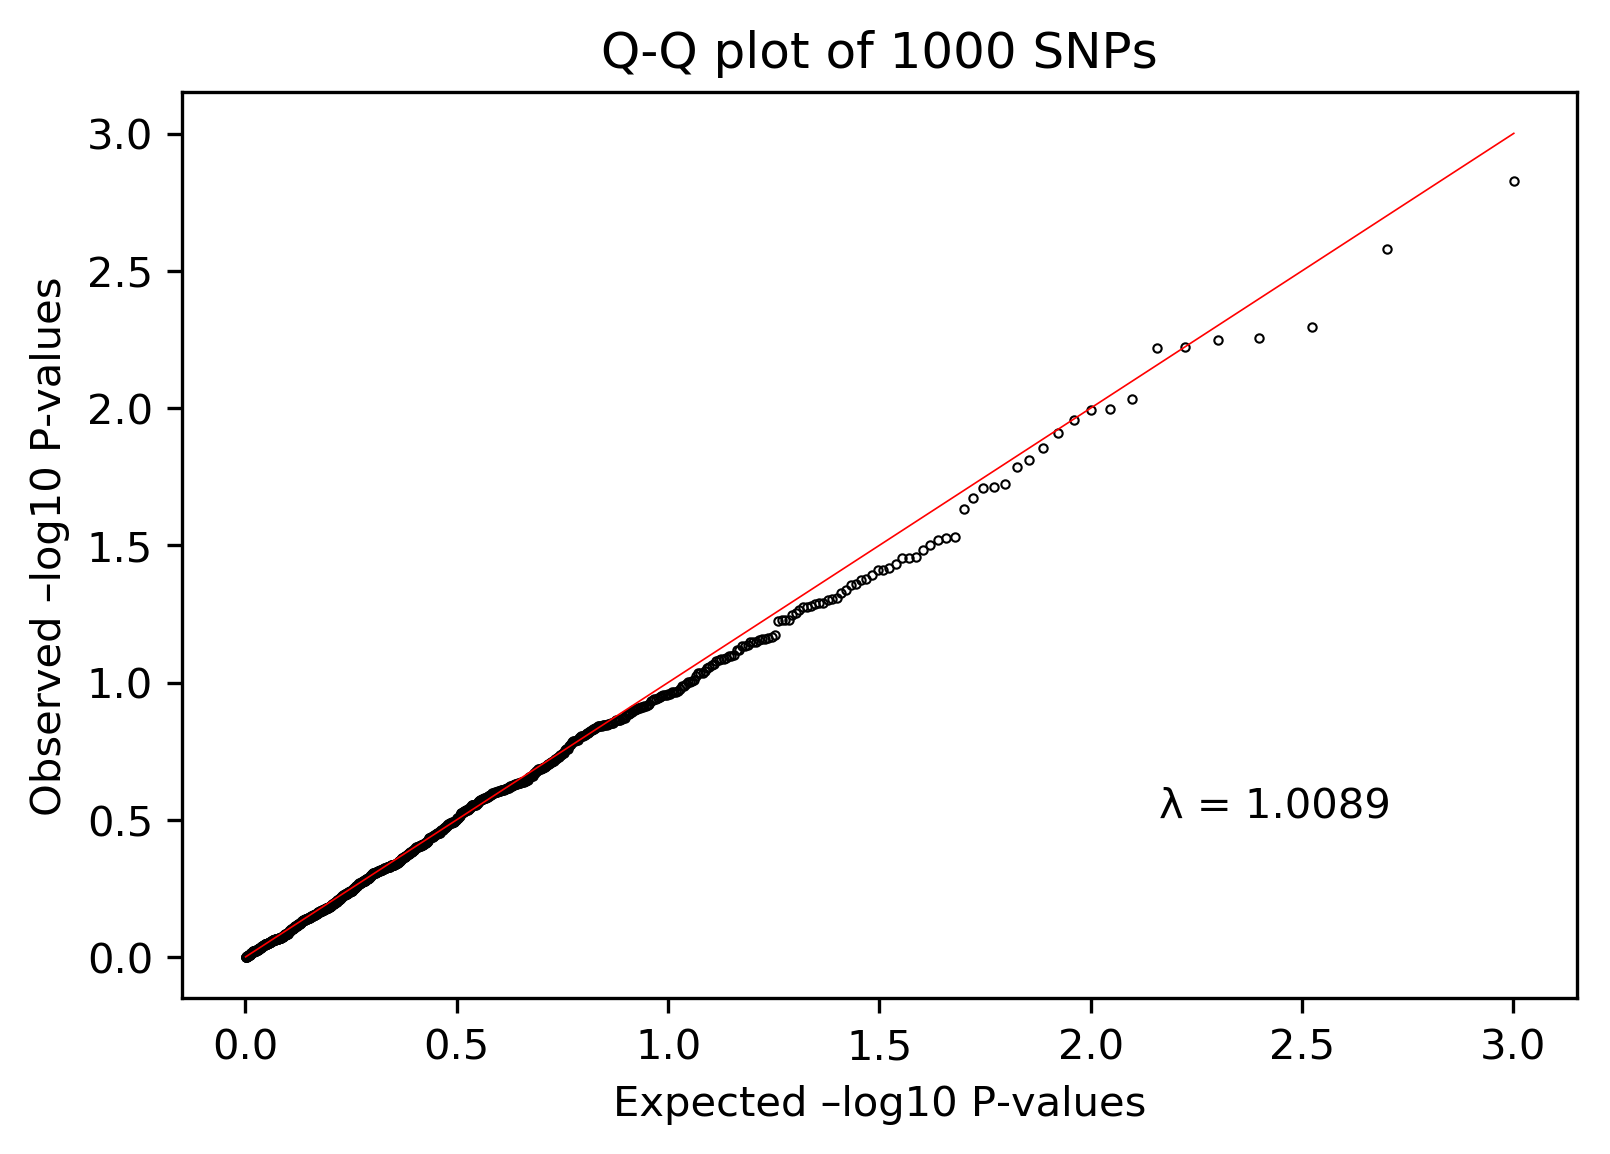

In [11]:
fig1, ax1, lambda1 = qqplot(filename=input_file, output='Results/1000SNPs.png',title='Q-Q plot of 1000 SNPs')

Getting associated SNPs of known SNPs from HaploReg
-- Waiting for HaploReg to return results...
  -- Number of SNPs queried: 100
-- Waiting for HaploReg to return results...
  -- Number of SNPs queried: 200
-- Waiting for HaploReg to return results...
  -- Number of SNPs queried: 300
Removing known SNPs...


(<Figure size 1800x1200 with 1 Axes>,
 1.0088931906852026)

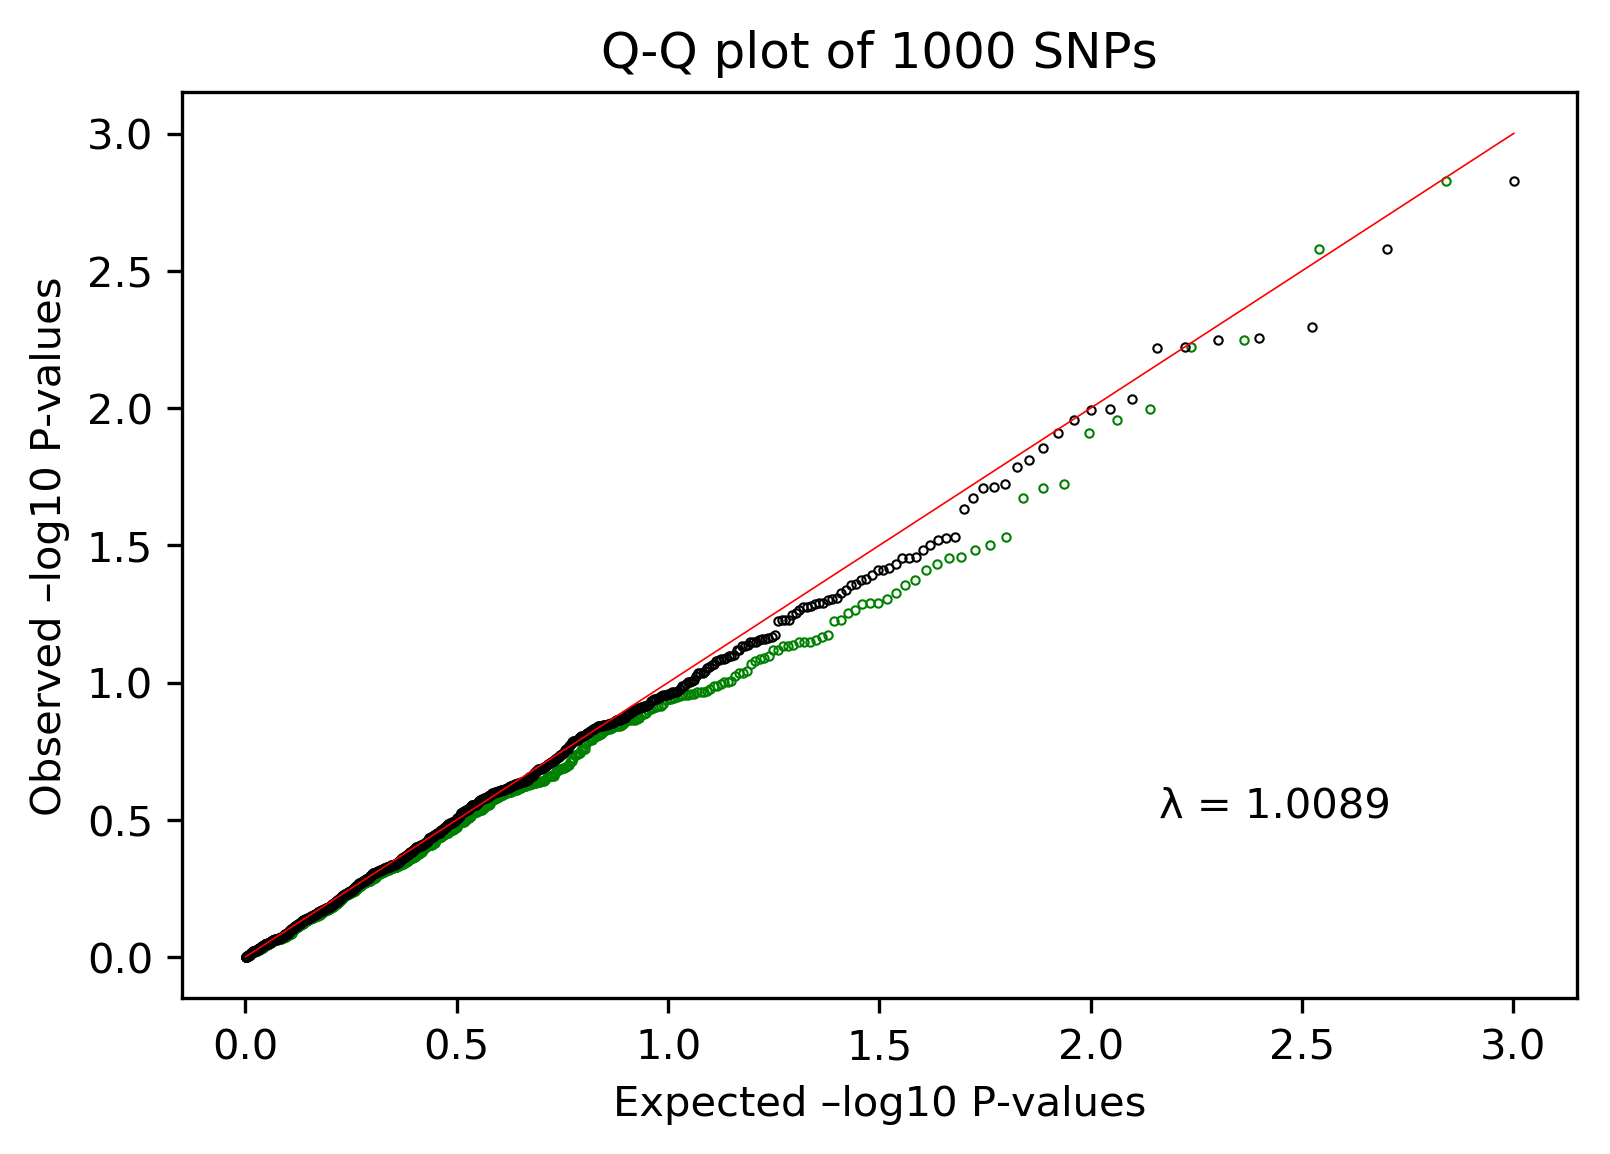

In [12]:
qqplot(filename=input_file,
       output='Results/1000SNPs_novel.png',
       title='Q-Q plot of 1000 SNPs',
       known_SNPs_filename=known_file,
       novel_filename = 'Results/novel_SNPs_from_1000.csv',
       plot_novel=True)

In [ ]:
qqplot(filename=input_file,
       output='Results/1000SNPs_empty_novel.png',
       title='Q-Q plot of 1000 SNPs',
       known_SNPs_filename=empty_with_title,
       novel_filename = 'Results/empty_novel.csv',
       plot_novel=True)

In [2]:
# Figure out how to plot 95% CI

from scipy.stats import beta
help(beta.ppf)

# def CI(percentage=0.95):   

Help on method ppf in module scipy.stats._distn_infrastructure:

ppf(q, *args, **kwds) method of scipy.stats._continuous_distns.beta_gen instance
    Percent point function (inverse of `cdf`) at q of the given RV.
    
    Parameters
    ----------
    q : array_like
        lower tail probability
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    x : array_like
        quantile corresponding to the lower tail probability q.



In [3]:
# -log10(qbeta(p = (1 - ci) / 2, shape1 = 1:n, shape2 = n:1)),
ci = 0.95
p_val = [0.2, 0.3, 0.5,0.1, 0.6, 0.35]
n = len(p_val)
a = [1,2,3,4,5,6]
# b = [i in range(1, n+1)]
b = [6,5,4,3,2,1]

In [7]:
x = beta.ppf(q=(1 - ci)/2, a=a, b=b)

In [27]:
df = __read_file(input_file)
p_val = df.loc[:,'P'].values

In [28]:
# Add a shaded into qqplotpillar box
#  Come back later
ci = 0.95
n = len(p_val)
a = list(range(1, n+1))
b = list(range(n, 0, -1))
clower = beta.ppf(q=(1-ci)/2, a = a, b = b)
cupper = beta.ppf(q=(1+ci)/2, a = a, b = b)

logCL = -np.log10(clower)
logCU = -np.log10(cupper)

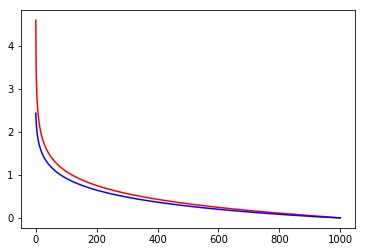

In [30]:
fig, ax = plt.subplots()
ax.plot(logCL, c='r')
ax.plot(logCU, c='b')